In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from sklearn import neighbors

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score



# EDA Validierung des Datensatzes (Florian Schmidt, Lucas Schmidt, Florian Wolf)

## Metadaten des Datensatzes
* Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

* Data available: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

* Attribute information
    medizinische variablen:  
        1 - Pregnancies = Anzahl der Schwangerschaften
        2 - Glucose = Glukosekonzentration nach Glukosetoleranztest
        3 - BloodPressure = Blutdruck (mg Hg)
        4 - SkinThickness = Dicke der Trizepshautfalte (mm)
        5 - Insulin = Insulin (μU/ml)
        6 - BMI = Body Mass Index (in kg/Körperhöhe in m)^2
        7 - DiabetesPedigreeFunction = Diabetes Stammbaumfunktion (bewertet die Wahrscheinlichkeit von Diabetes aufgrund der Familienanamnese)
        8 - Age = Alter (Jahre)
        9 - Outcome = nicht erkrankt (=0), erkrankt (=1)
        
## Übersicht über den Datensatz
Als Erstes haben wir den Datensatz eingelesen und verschiedene Übersichtsmethoden darauf angewendet.

In [215]:
diabetes = pd.read_csv("diabetes.csv")

In [216]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [217]:
diabetes.shape

(768, 9)

In [218]:
diabetes.duplicated().sum()

0

In [219]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [220]:
diabetes.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [221]:
diabetes["Outcome"].value_counts(0)

Outcome
0    500
1    268
Name: count, dtype: int64

In [222]:
def zaehle_nullwerte_nach_outcome(df):
    ergebnisse = {}

    # Zählt die Anzahl der Werte, die genau 0 sind, in jeder Spalte für Outcome 0 und 1
    for spalte in df.columns:
        if spalte != 'Outcome': # Überspringt die Spalte 'Outcome'
            nullwerte_outcome_0 = df[(df['Outcome'] == 0) & (df[spalte] == 0)].shape[0]
            nullwerte_outcome_1 = df[(df['Outcome'] == 1) & (df[spalte] == 0)].shape[0]

            # Fügt die Ergebnisse für die aktuelle Spalte hinzu
            ergebnisse[spalte] = {
                '0': nullwerte_outcome_0,
                '1': nullwerte_outcome_1
            }

    return ergebnisse

# Beispielaufruf der Funktion
ergebnisse = zaehle_nullwerte_nach_outcome(diabetes)

print("Anzahl der Nullwerte in den Spalten für Outcome 0 und 1:")
for spalte, zaehler in ergebnisse.items():
    print(f"{spalte}: {zaehler}")

Anzahl der Nullwerte in den Spalten für Outcome 0 und 1:
Pregnancies: {'0': 73, '1': 38}
Glucose: {'0': 3, '1': 2}
BloodPressure: {'0': 19, '1': 16}
SkinThickness: {'0': 139, '1': 88}
Insulin: {'0': 236, '1': 138}
BMI: {'0': 9, '1': 2}
DiabetesPedigreeFunction: {'0': 0, '1': 0}
Age: {'0': 0, '1': 0}


## Ergebnis Übersicht Datensatz
Mit den vorherigen Methoden und zusammen mit dem Datenblatt konnten wir uns folgende Erkenntnisse erarbeiten.
- Anzahl der Datensätze: 768
- Es gibt keine Duplikate oder nicht numerischen Werte wie null oder NaN.
- Es gibt viel mehr gesunde als ungesunde Datensätze (500 zu 268)
- Das Attribut "Outcome" gibt erkrankt oder gesund an und ist damit die wichtige Ergebnisgröße, die wir im weiteren Verlauf genauer betrachten wollen
- Das Zählen der Werte, die den Wert 0 haben, hat ergeben, dass einige Messungen fehlerbehaftet sein müssen, da Werte wie ein BMI von 0 nicht möglich sind. Das heißt, dass diese für die spätere Betrachtung angepasst werden müssen.

Bei den folgenden Attributen ist der Wert 0 medizinisch unmöglich:
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

## Daten aufbereiten
Als Nächstes werden die unmöglichen Daten ersetzt. Dabei haben wir uns für die Median-Imputation entschieden. Diese ist einfach zu implementieren und sorgt für einen vollständigen Datensatz. Außerdem ist sie robust gegenüber Ausreißern, sodass wir da keine Sorgen haben. Jedoch sorgt diese Methode auch dafür, dass sich unsere Verteilung verändert. [Quelle](https://medium.com/analytics-vidhya/feature-engineering-part-1-mean-median-imputation-761043b95379)



In [223]:
def median_target(var):
    temp = diabetes[diabetes[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp


def change_value(var):
    diabetes.loc[(diabetes['Outcome'] == 0) & (diabetes[var].isnull()), var] = median_target(var)[var][0]
    diabetes.loc[(diabetes['Outcome'] == 1) & (diabetes[var].isnull()), var] = median_target(var)[var][1]

In [224]:
diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

change_value("Insulin")
change_value("Glucose")
change_value("SkinThickness")
change_value("BloodPressure")
change_value("BMI")

## Bootstrapping

Da es überwiegend viele Datensätze für gesunde gibt, haben wir uns dafür entschieden, Bootstrapping zu verwenden, um die Übergewichtung zu verhindern. Bootstrapping ist eine Wiederholungsstichprobentechnik, die bei der Schätzung der Unsicherheit eines statistischen Modells hilft. Dabei wird der ursprüngliche Datensatz durch eine Stichprobe ersetzt und es werden mehrere neue Datensätze mit der gleichen Größe wie der ursprüngliche Datensatz erzeugt. [Quelle](https://www.kdnuggets.com/2023/03/bootstrapping.html)
Wir verwenden eine abgewandelte nicht so komplexe Form des Bootstrappings, nämlich nur das Sampling, also das Auswählen von zufälligen Datensätzen. Da wenden wir einmal für kranke und einmal für gesunde Datensätze an und erhalten damit einen ausgeglichenen Datensatz, wo weder gesund noch krank übergewichtet ist.

In [225]:
H = diabetes[diabetes['Outcome'] == 0]
D = diabetes[diabetes['Outcome'] == 1]

sample_size = 250

# Bootstrapping-Verfahren für gesunde Personen
H_sample = H.sample(n=sample_size, replace=True, random_state=42)

# Bootstrapping-Verfahren für nicht gesunde Personen
D_sample = D.sample(n=sample_size, replace=True, random_state=42)

diabetes = pd.concat([H_sample, D_sample])

## Detaillierte Datenübersicht

Jetzt wollen wir uns nochmal einen genauen Überblick über die einzelnen Werte und ihre Verteilung anschauen. Dabei wollten wir einfach nochmal ein Gefühl bekommen, wie sind gesunde und kranke Werte zueinander verhalten.

In [226]:
def plt_detail_view(attr, title, xlabel):
    H = diabetes.loc[diabetes["Outcome"] == 0, attr]
    D = diabetes.loc[diabetes["Outcome"] == 1, attr]

    plt.hist(H, alpha=0.5, label='gesund')
    plt.hist(D, alpha=0.5, label='erkrankt')
    plt.legend(title='Health')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Anzahl Personen")

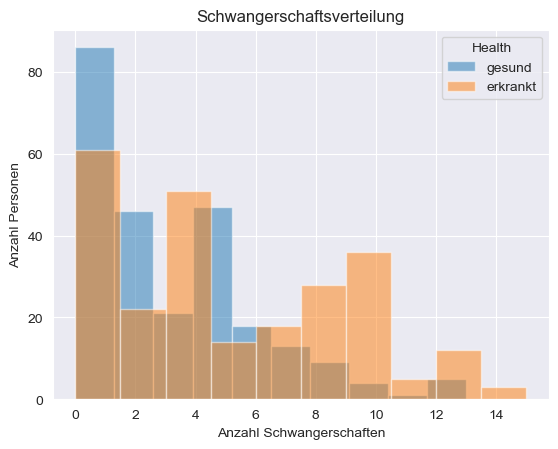

In [227]:
# Schwangerschaften
plt_detail_view('Pregnancies', 'Schwangerschaftsverteilung', 'Anzahl Schwangerschaften')

In dem Diagramm sieht man, dass der Datensatz bei Frauen mit mehr Schwangerschaften mehr kranke Frauen hat.

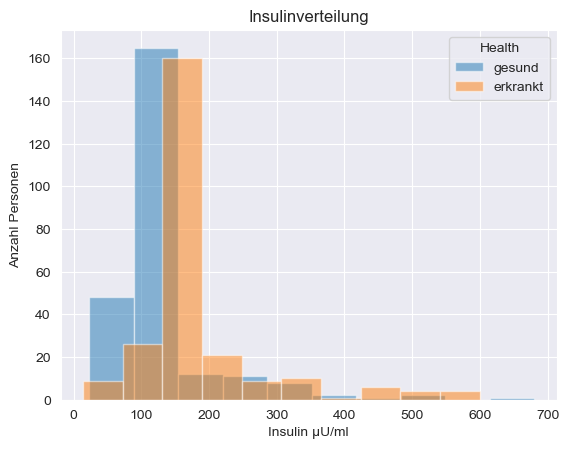

In [228]:
# Insulin
plt_detail_view('Insulin', 'Insulinverteilung', 'Insulin µU/ml')

In dem Diagramm sieht man, dass Frauen mit höherem Insulinspiegel eher erkrankt sind.
Hier sieht man, dass durch die Median-Imputation sehr deutlich eine hohe Konzentration an dem Median auftritt.


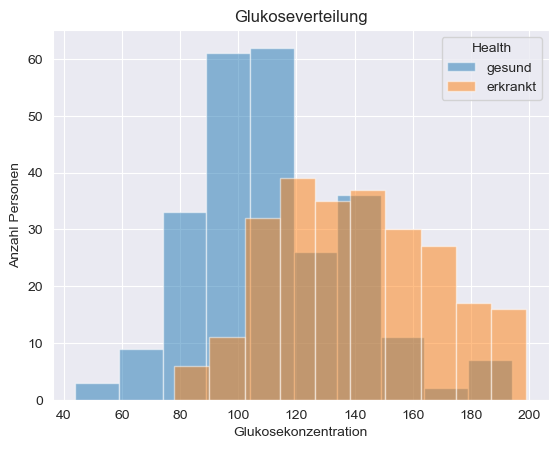

In [229]:
# Glukose
plt_detail_view('Glucose', 'Glukoseverteilung', 'Glukosekonzentration')

In dem Diagramm sieht man deutlich, dass bei höherem Glukosegehalt mehr Frauen erkrankt sind.


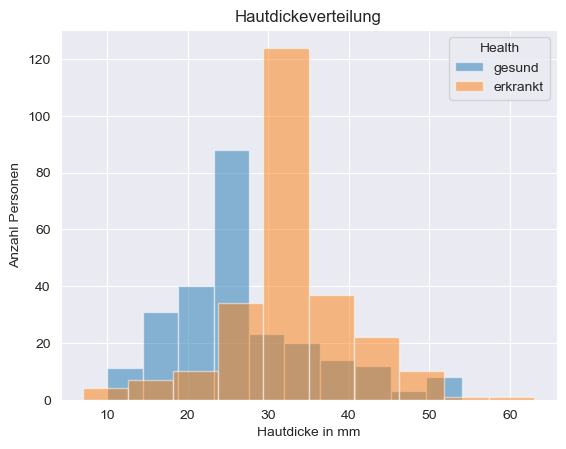

In [230]:
# Hautdicke
plt_detail_view('SkinThickness', 'Hautdickeverteilung', 'Hautdicke in mm')

In dem Diagramm sieht man, dass erkrankte Frauen eher eine dickere Haut haben.
Hier sieht man, dass durch die Median-Imputation sehr deutlich eine hohe Konzentration an dem Median auftritt.

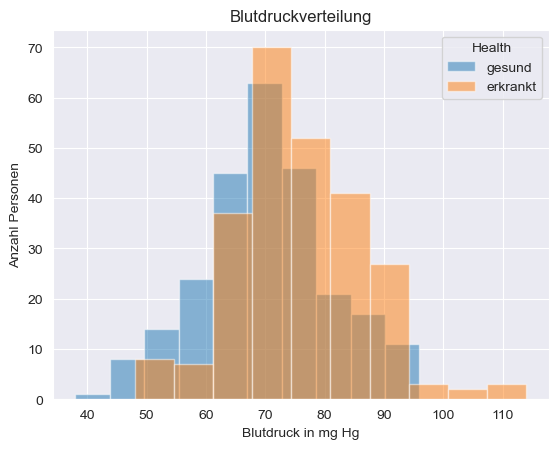

In [231]:
# Blutdruck
plt_detail_view('BloodPressure', 'Blutdruckverteilung', 'Blutdruck in mg Hg')

In dem Diagramm sieht man, dass Frauen mit höherem Blutdruck eher an Diabetes erkrankt sind.

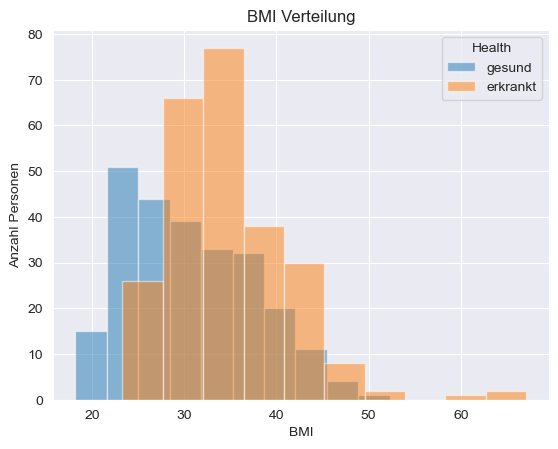

In [232]:
# BMI
plt_detail_view('BMI', 'BMI Verteilung', 'BMI')

In dem Diagramm sieht man, dass Frauen mit einem höheren BMI eher erkrankt sind

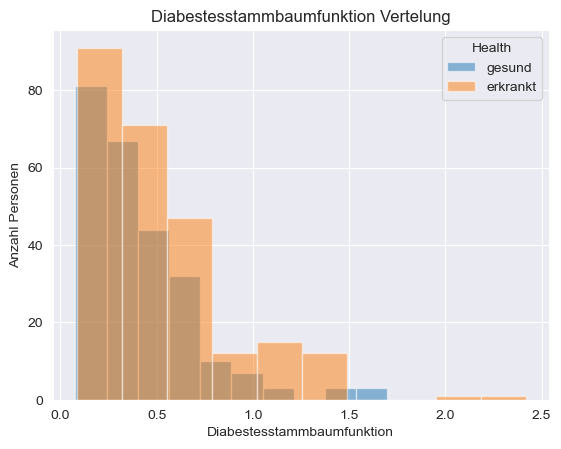

In [233]:
# Diabestesstammbaumfunktion
plt_detail_view('DiabetesPedigreeFunction', 'Diabestesstammbaumfunktion Vertelung', 'Diabestesstammbaumfunktion')

In dem Diagramm sieht man, dass die Balken sich sehr stark überlagern. Es gibt nur eine kleine Anzahl von Frauen, die bei höherer Stammbaumfunktion eher krank als gesund sind.

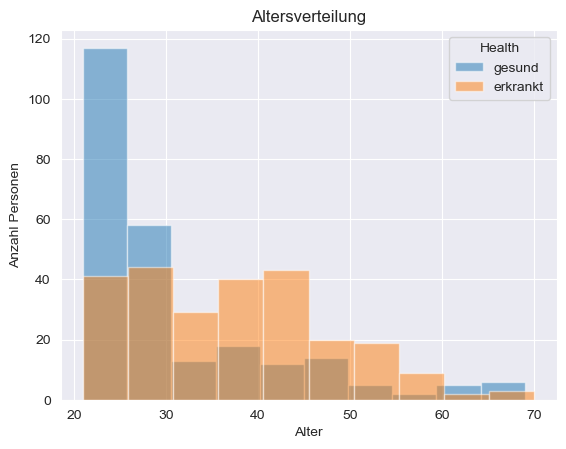

In [234]:
# Alter
plt_detail_view('Age', 'Altersverteilung', 'Alter')

In dem Diagramm sieht man, dass bei steigendem Alter auch die Erkrankung öfter auftritt. 
Hier ist besonders, dass in unserem Datensatz viele jüngere Frauen sind.

## Multivariante Analyse

Zum Abschluss der EDA schauen wir uns nochmal die Korrelationen zwischen den einzelnen Eigenschaften an. Hier interessiert uns besonders die Korrelationen mit dem Wert Outcome.

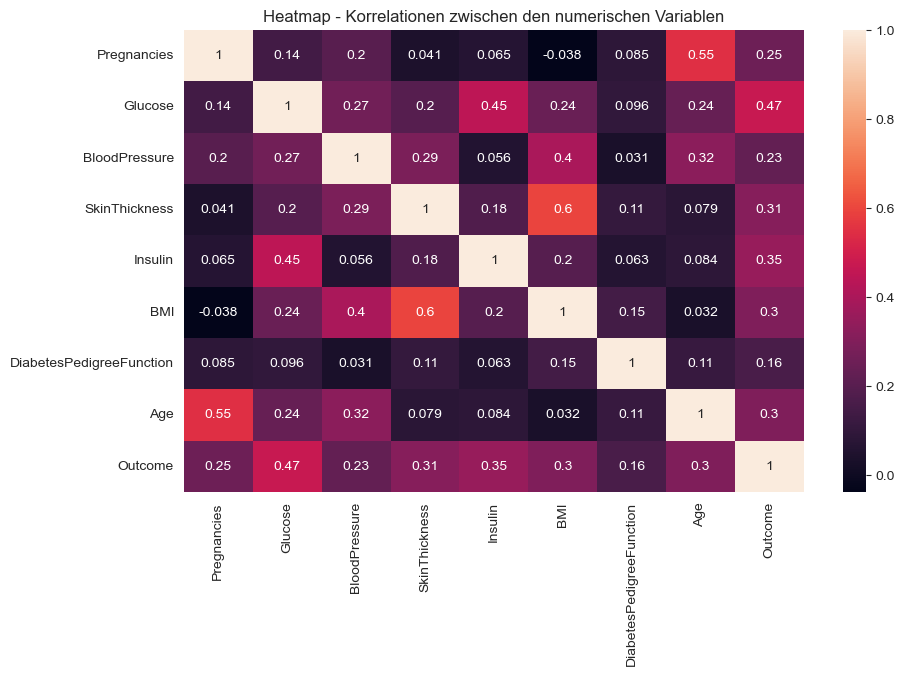

In [235]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(diabetes.corr(),annot=True,ax=ax)
plt.title("Heatmap - Korrelationen zwischen den numerischen Variablen",fontsize=12)
plt.show()

## Fazit EDA

- Wir haben einen Datensatz zum Weiterarbeiten mit 500 vollständigen Datensätzen
- Outcome ist die Zielvariable für die Modelle
- Outcome hat zu allen anderen Eigenschaften Korrelation.
- Es fehlen verhältnismäßig viele Werte bei Insulin und Hautdicke, sodass für diese Werte viele Werte ergänzt werden mussten. Das bedeutet auch, dass diese Werte eher nicht so aussagekräftig sind und diese später ggf. nochmal speziell bewertet werden müssen.
- Nachteile:
  - Wir haben nur 500 Datensätze
  - Es haben viele Daten gefehlt
  - Es sind nur 8 Eigenschaften zur Verfügung. Mit weiteren Informationen wie Ernährung könnte man in den folgenden Phasen genauere Beurteilungen und Modellierungen vornehmen.

# Modellierung

## Logistic Regression (Florian Wolf)

In [236]:
x = diabetes.drop(columns=['Outcome'], axis=1)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=43)

In [237]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [238]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=1)
logreg.fit(X_train, y_train)
# Vorhersage für Testdaten
y_pred_lr = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


### Evaluation des Modells

In [239]:
cflr = confusion_matrix(y_test,y_pred_lr)
pd.crosstab(y_test, y_pred_lr, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,59,15,74
1,18,58,76
All,77,73,150


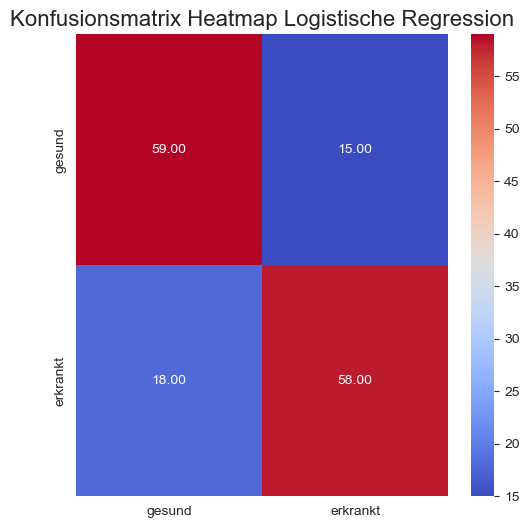

In [256]:
plt.figure(figsize=(6, 6))
x_axis_labels = ['gesund', 'erkrankt'] # labels for x-axis
y_axis_labels = ['gesund', 'erkrankt'] # labels for y-axis
sns.heatmap(cflr, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", cmap='coolwarm')
plt.title("Konfusionsmatrix Heatmap Logistische Regression", fontsize=16)
plt.show()

In [241]:
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78        74
           1       0.79      0.76      0.78        76

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150


**Modellbewertung Logistische Regression**
- geringste Genauigkeit aller Modelle (78%)
- Positivfall wird wird etwas häufiger erkannt, dafür mit etwas mehr false positive:
    - 77% aller tatsächl. Negativfälle und 79% aller Positivfälle werden erkannt
    - Negativfall hat 20% false negative
    - Positiv: 24% false positive

**Classification Report**

1. Precision (Präzision):
Der Anteil der wahren positiven Vorhersagen unter allen positiven Vorhersagen.
Precision = TP / (TP + FP)

2. Recall (Rückruf):
Der Anteil der wahren positiven Vorhersagen unter allen tatsächlichen positiven Instanzen.
Recall = TP / (TP + FN)

3. F1-Score:
Das harmonische Mittel aus Precision und Recall.
F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

4. Support:
Die Anzahl der tatsächlichen Instanzen für jede Klasse.

5. Accuracy (Genauigkeit):
Der Anteil der korrekten Vorhersagen insgesamt.
Accuracy = (TP + TN) / (TP + TN + FP + FN)

6. Macro AVG (Makro-Durchschnitt):
Der Durchschnitt der Metriken für jede Klasse, ohne dabei die Klassenhäufigkeiten zu berücksichtigen.

7. Weighted AVG (Gewichteter Durchschnitt):
Der gewichtete Durchschnitt der Metriken für jede Klasse, wobei die Klassenhäufigkeiten berücksichtigt werden.

Eine ROC-Kurve nahe der Diagonalen deutet auf einen Zufallsprozess hin: Werte nahe der Diagonalen bedeuten eine gleiche Trefferquote und Falschpositivquote, was der zu erwartenden Trefferhäufigkeit eines Zufallsprozesses entspricht. Die ideale ROC-Kurve steigt zunächst senkrecht an (die Trefferquote liegt nahe bei 100 %, während die Fehlerquote anfangs noch nahe bei 0 % bleibt), erst danach steigt die Falsch-Positiv-Rate an. Eine ROC-Kurve, die deutlich unterhalb der Diagonalen bleibt, deutet darauf hin, dass die Werte falsch interpretiert wurden.


**AUC-ROC (Area Under the ROC Curve):** Die Fläche unter der ROC-Kurve. Eine AUC von 1,0 bedeutet perfekte Vorhersagen, während eine AUC von 0,5 auf eine zufällige Vorhersage hinweist.


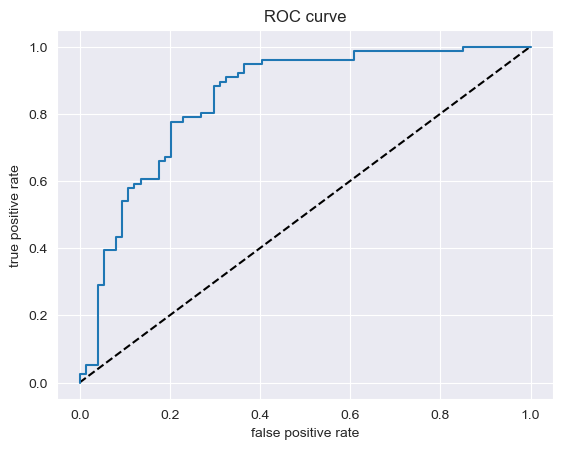

In [242]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curve')
plt.show()

In [243]:
print("ROC Accuracy: {}".format(roc_auc_score(y_test,y_pred_proba)))

ROC Accuracy: 0.8453058321479374


## Random Forest (Florian Schmidt)

In [257]:
from sklearn.feature_selection import RFE

model = RandomForestClassifier(criterion='gini', bootstrap=True, n_estimators=1000)
model.fit(X_train,y_train)

importances = model.feature_importances_
rfe = RFE(estimator=model, n_features_to_select=7)
X_train_sel = rfe.fit_transform(X_train,y_train)

In [258]:
y_pred_rf = model.predict(X_test)

### Evaluation des Modells

In [259]:
cfrf=confusion_matrix(y_test,y_pred_rf)
pd.crosstab(y_test, y_pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,67,7,74
1,7,69,76
All,74,76,150


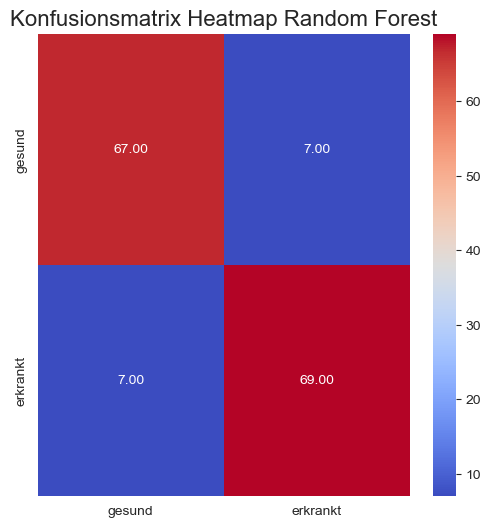

In [260]:
plt.figure(figsize=(6, 6))
x_axis_labels = ['gesund', 'erkrankt'] # labels for x-axis
y_axis_labels = ['gesund', 'erkrankt'] # labels for y-axis
sns.heatmap(cfrf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", cmap='coolwarm')
plt.title("Konfusionsmatrix Heatmap Random Forest", fontsize=16)
plt.show()

In [261]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        74
           1       0.91      0.91      0.91        76

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150


**Modellbewertung Random Forest:**
- recht hohe Gesamtgenauigkeit (ca. 90-91%) für sowohl Positiv- als auch Negativvorhersagen
- false positive/false negative mittelmäßig mit 9-10% in beiden Fällen
- alle Leistungsmerkmale stiegen durchschnittlich leicht an nach Ignorieren des unwichtigsten Merkmals: **DiabetesPedigreeFunction** 

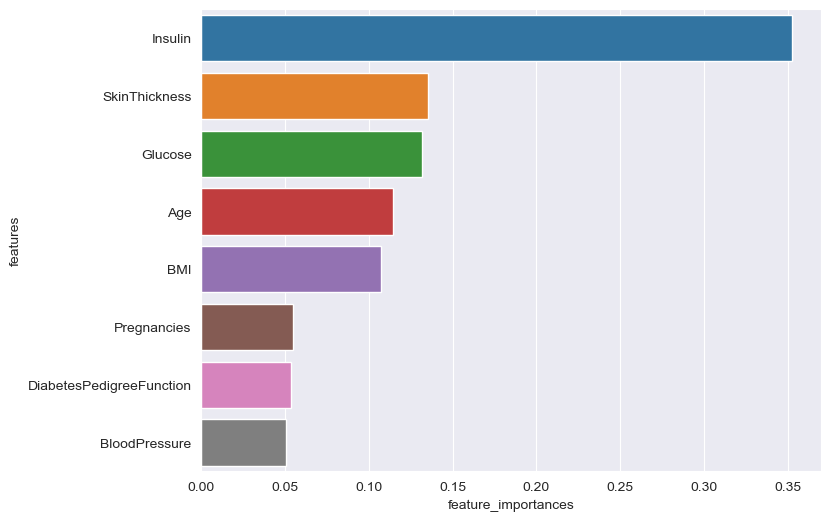

In [262]:
fi_df = pd.DataFrame({
    "feature_importances" : model.feature_importances_,
    "features" : x.columns
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x="feature_importances", y="features", data=fi_df)
plt.show()

- 8 Features, jedoch flossen nur 7 in die Erstellung des **Random Forest** ein: unwichtigstes Feature *BloodPressure* wird ignoriert

## kNN (Lucas Schmidt)

Text(0.5, 1.0, 'Wahrscheinlichkeiten')

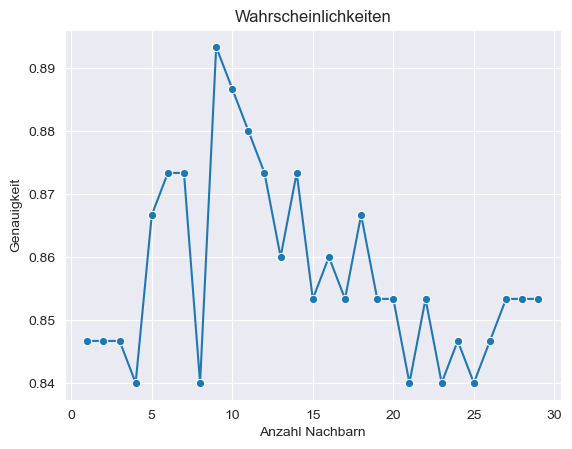

In [250]:
k_values = [i for i in range (1,30)]
scores = []



for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    score = cross_val_score(knn, x, y, cv=5)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores.append(classification_report(y_test,y_pred_knn,output_dict=True)["accuracy"])
    


sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("Anzahl Nachbarn")
plt.ylabel("Genauigkeit")
plt.title("Wahrscheinlichkeiten")

Wie im Diagramm zu sehen, ist die Genauigkeit bei 9 Nachbarn am größten, weswegen wir uns im anschluss für n_neighbors = 9 entschieden haben.

In [251]:
weights = 'distance'
n_neighbors = 9
clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=9, weights='distance')

In [265]:
y_pred_knn = clf.predict(X_test)

### Evaluation des Modells

In [266]:
cfknn=confusion_matrix(y_test,y_pred_knn)
pd.crosstab(y_test, y_pred_knn, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,61,13,74
1,3,73,76
All,64,86,150


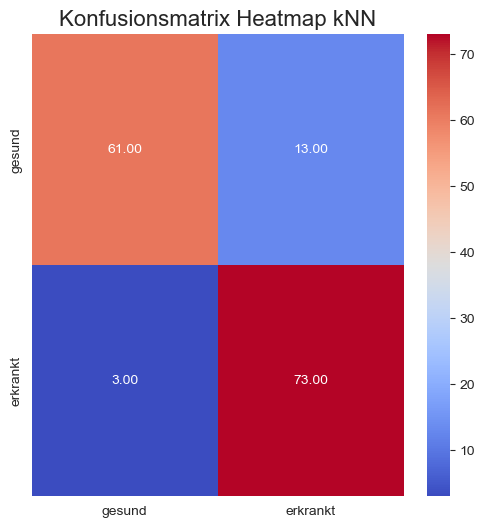

In [263]:
plt.figure(figsize=(6, 6))
x_axis_labels = ['gesund', 'erkrankt'] # labels for x-axis
y_axis_labels = ['gesund', 'erkrankt'] # labels for y-axis
sns.heatmap(cfknn, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", cmap='coolwarm')
plt.title("Konfusionsmatrix Heatmap kNN", fontsize=16)
plt.show()

In [254]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88        74
           1       0.85      0.96      0.90        76

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150


**Modellbewertung k-Nearest-Neighbours**
- Accuracy über beide Fälle ist mit 89% hoch, aber leicht geringer als bei Random Forest
- erkannt negative/gesunde Fälle (Fall 0) haben eine hohe Sicherheit (5% false negative), jedoch werden nur 82% der tatsächlich gesunden Fälle erkannt
- 85% aller tatsächlichen Diabetes-Fälle werden erkannt, aber dann mit hoher Sicherheit (nur 4% false positive)

## Vergleich der Modelle

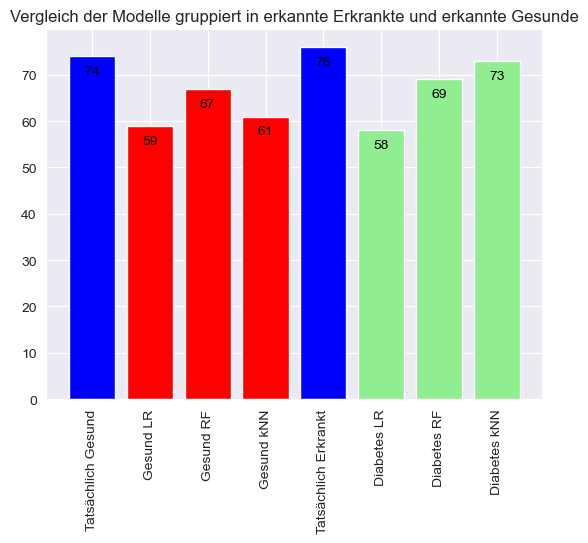

In [264]:
recall_tat = 74
recall_LR = cflr[0,0]
recall_RF = cfrf[0,0]
recall_kNN = cfknn[0,0]
precision_tat = 76
precision_LR = cflr[1,1]
precision_RF = cfrf[1,1]
precision_kNN = cfknn[1,1]

werte = [recall_tat,recall_LR, recall_RF, recall_kNN,precision_tat,precision_LR, precision_RF,precision_kNN]
farben = ['blue','red', 'red', 'red', 'blue', 'lightgreen', 'lightgreen','lightgreen']
bars = plt.bar(range(len(werte)), werte, color = farben)

kategorien = ['Tatsächlich Gesund','Gesund LR', 'Gesund RF','Gesund kNN','Tatsächlich Erkrankt', 'Diabetes LR','Diabetes RF', 'Diabetes kNN']
plt.xticks(range(len(werte)), kategorien)

for bar, wert in zip(bars, werte):
    plt.annotate(str(wert), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, -15),
             textcoords='offset points', ha='center', va='bottom', color='black')

plt.title("Vergleich der Modelle gruppiert in erkannte Erkrankte und erkannte Gesunde")
plt.tick_params(axis='x',labelrotation = 90)

# Zusammenfassung und Auswertung (Florian Schmidt, Lucas Schmidt, Florian Wolf)

Für das Projekt haben wir den Diabetes-Datensatz des US-amerikanischen National Institute of Diabetes and Digestive and Kidney Diseases ausgewählt.

Unser Ziel war es, anhand bestimmter diagnostischer Merkmale präzise vorherzusagen, ob eine Patientin am Anfang einer Diabeteserkrankung steht oder nicht. Wir haben ermittelt, welche Merkmale besonders starken Einfluss auf das Erkrankungsrisiko haben.

Während der explorativen Datenanalyse fiel auf, dass der vorliegende Datensatz fehlerhafte oder inkorrekte Werte aufweist. Diese Werte wurden bereinigt und der Datensatz wurde mithilfe von Bootstrapping gleichmäßig in gesunde und erkrankte Personen aufgeteilt.

Die Ersetzung von Werten mittels Median-Imputation führt zu einer extremen Häufung der Mittelwerte in den Kategorien **Insulin** und **SkinThickness**. Fast 50% aller Werte bei Insulin und fast 30% aller Werte bei SkinThickness werden dadurch generiert.   Dies könnte bei den Modellen zu Fehlern führen und somit die Genauigkeit beeinträchtigen.   
  
Da wir kategoriale Werte vorhersagen, haben wir uns für die supervised Modelle Logistische Regression, Random Forest und k-nearest neighbors (kNN) entschieden. Dabei wurden alle Modelle optimiert, um die höchstmögliche Vorhersagegenauigkeit zu erzielen.

Im Vergleich der Modelle weist die **Logistische Regression** eine Genauigkeit von 78,6% auf, was im Vergleich zu den anderen Modellen niedriger ist. Sie hat 59 von 74 Personen korrekt als gesund und 58 von 76 Personen korrekt als an Diabetes erkrankt ermittelt.



Das **Random-Forest-Modell** hat eine Genauigkeit von 91%. Es bietet im Vergleich zu kNN und logistischer Regression die höchste Genauigkeit bei der Kategorisierung der gesunden Patienten. Es identifiziert damit 66 von 74 Patienten als gesund, die tatsächlich gesund sind. Es kategorisiert lediglich 8 Personen als krank, die tatsächlich gesund sind. Allerdings erfasst es auch 8 Personen als gesund, die tatsächlich krank sind. Das bedeutet, dass 69 von 76 Patienten korrekt als krank klassifiziert wurden. Das Modell ist zwar deutlich genauer als das Modell mit logistischer Regression, jedoch nicht so genau wie das Modell, welches mittels kNN klassifiziert wurde. Bei mehrfacher Ausführung schwankt die Genauigkeit des Modells zwischen 90 und 91 %.

Das Modell, welches die genauesten Vorhersagen macht und damit am besten ist, ist kNN. Es hat zwar im Vergleich zu Random Forest eine geringere Gesamtgenauigkeit von 89%, erkennt jedoch nur 3 Patienten als fälschlicherweise gesund, obwohl diese an Diabetes erkrankt sind. Das bedeutet, dass 73 von 76 Personen, die tatsächlich an Diabetes erkrankt sind, richtig klassifiziert werden. Allerdings werden auch 13 Patienten als erkrankt klassifiziert, die tatsächlich aber gesund sind. Im Vergleich zum Random Forest ist dieser Wert jedoch sehr hoch.
     


Unserer Meinung nach ist diese Klassifikation mittels kNN trotzdem besser als die Klassifikation mittels Random Forest, da vor allem die Identifizierung von diabeteserkrankten Patienten so genau ist wie in keinem anderen Modell. Bei den falsch kategorisierten gesunden Patienten werden voraussichtlich keine weiteren Untersuchungen vorgenommen. Das hat zur Folge, dass sich das Krankheitsbild der Personengruppe verschlechtert, da wahrscheinlich keine Behandlung eingeleitet wird.  

## Quellen (Florian Schmidt, Lucas Schmidt, Florian Wolf)
  - Median-Imputation:  https://medium.com/analytics-vidhya/feature-engineering-part-1-mean-median-imputation-761043b95379
  - Bootstrapping:  https://www.kdnuggets.com/2023/03/bootstrapping.html